In [54]:
import tensorflow as tf
from matplotlib import pyplot as plt
from common import *

In [55]:
MODEL_PATH = '/home/pwl/Projects/tiny-tracking/tflite_models/full/yolox_nano.tflite'
IMG_PATH = '../COCO/val2017/000000000139.jpg'
LABEL_PATH = 'coco_labels_actual.txt'

In [56]:
interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_img_shape = tuple(input_shape[1:3])
input_type = input_details[0]['dtype']
print("Input tensor shape: ", input_shape, input_type)

Input tensor shape:  [  1 416 416   3] <class 'numpy.float32'>


In [57]:
original_img, scaled_img = preprocess_image(IMG_PATH, input_img_shape, input_type)

In [58]:
interpreter.set_tensor(input_details[0]['index'], scaled_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [59]:
output_data

array([[1.9079475e+00, 1.6221523e+02, 1.0300955e+02, 2.6225293e+02,
        8.7397069e-01, 6.2000000e+01],
       [1.8891403e+02, 2.1408578e+02, 2.3281665e+02, 3.1317795e+02,
        7.3449075e-01, 5.6000000e+01],
       [2.4473093e+02, 2.1776045e+02, 2.8595731e+02, 3.0847382e+02,
        6.3589656e-01, 5.6000000e+01],
       [1.4386647e+02, 1.7468304e+02, 1.7512553e+02, 2.0785428e+02,
        4.2077059e-01, 5.8000000e+01],
       [3.5687183e+02, 3.0182925e+02, 3.8242303e+02, 3.9230380e+02,
        3.2706454e-01, 7.5000000e+01],
       [3.6229095e+02, 2.0234749e+02, 4.1629419e+02, 2.7127881e+02,
        3.1823230e-01, 6.2000000e+01],
       [1.9028572e+02, 2.1627650e+02, 2.5551222e+02, 3.1265115e+02,
        2.9221025e-01, 6.0000000e+01],
       [1.4681372e+02, 1.7473810e+02, 1.7441843e+02, 2.0927505e+02,
        2.6373807e-01, 5.8000000e+01],
       [1.4681372e+02, 1.7473810e+02, 1.7441843e+02, 2.0927505e+02,
        2.6373807e-01, 5.8000000e+01],
       [1.4681372e+02, 1.7473810e+02,

In [60]:
bboxes = output_data[:, 0:4]
scores = output_data[:, 4]
class_ids = output_data[:, 5]

In [61]:
nms_idxs = tf.image.non_max_suppression(
    bboxes,
    scores,
    max_output_size=100,
    iou_threshold=0.4,
    score_threshold=0.3
    )
bboxes = bboxes[nms_idxs]
class_ids = class_ids[nms_idxs]
scores = scores[nms_idxs]

fix_missing_labels(class_ids)

class_ids += 1

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic-light', 11: 'fire-hydrant', 12: 'street-sign', 13: 'stop-sign', 14: 'parking-meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 26: 'hat', 27: 'backpack', 28: 'umbrella', 29: 'shoe', 30: 'eye-glasses', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports-ball', 38: 'kite', 39: 'baseball-bat', 40: 'baseball-glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis-racket', 44: 'bottle', 45: 'plate', 46: 'wine-glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot-dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted-plant', 65: 'bed', 66: 'mirror', 67: 'dining-table', 68: 'window', 69: 'de

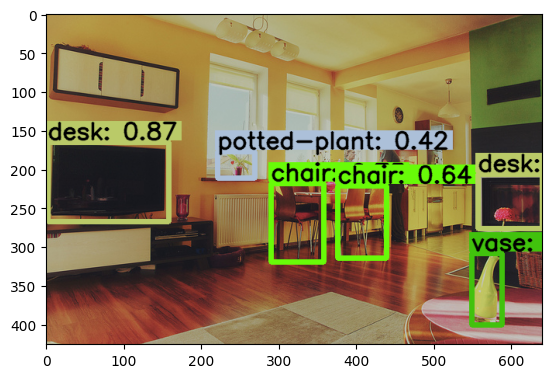

In [62]:
labels = get_coco_labels(LABEL_PATH)
print(labels)
colors = get_colors_from_labels(labels)

for bbox, score, class_id in zip(bboxes, scores, class_ids):

    label = labels[int(class_id)]
    color = tuple([int(c) for c in colors[int(class_id)]])

    x_min, y_min, x_max, y_max = bbox

    # Scale bounding box to original image.
    # Note: This YOLOX model uses letterboxing, so we need to scale the bounding box to the original image size.
    x_min = int(x_min / scaled_img.shape[2] * original_img.shape[1])
    y_min = int(y_min / scaled_img.shape[1] * original_img.shape[0])
    x_max = int(x_max / scaled_img.shape[2] * original_img.shape[1])
    y_max = int(y_max / scaled_img.shape[1] * original_img.shape[0])

    print('[',x_min, y_min, x_max, y_max,']', f'{score:.2f}, {class_id}', label)
    
    draw_bbox_with_label(original_img, x_min, y_min, x_max, y_max, score, label, color)

plt.imshow(original_img)
